In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import pymc as pm
import arviz as az

WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [2]:
from datetime import datetime
myrun_start = datetime.now()

# Генерим выборки эксперимента с монетой

## задаем "скрытые" пераметры генерации данных

In [3]:
eps = 0.02          # разбаланс сторон монеты
p = 0.5*(1+eps)     # вероятность орла при одном броске монеты
n = 10              # количество подбрасывания монеты в одном эксперименте
nof_rep = 100       # количество повторов опыта с n подбрасываниями монеты
print('\nFYI: скрытый параметр монетки p =', p)


FYI: скрытый параметр монетки p = 0.51


## генерим данные

In [4]:
Xi = st.bernoulli(p)

X = np.array([ Xi.rvs(size=n) for i in range(nof_rep)])
X.shape

(100, 10)

In [5]:
X[:5]

array([[1, 0, 1, 0, 1, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 0, 1, 0, 0, 0, 1],
       [0, 1, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 1, 0, 0]])

### визуализация данных

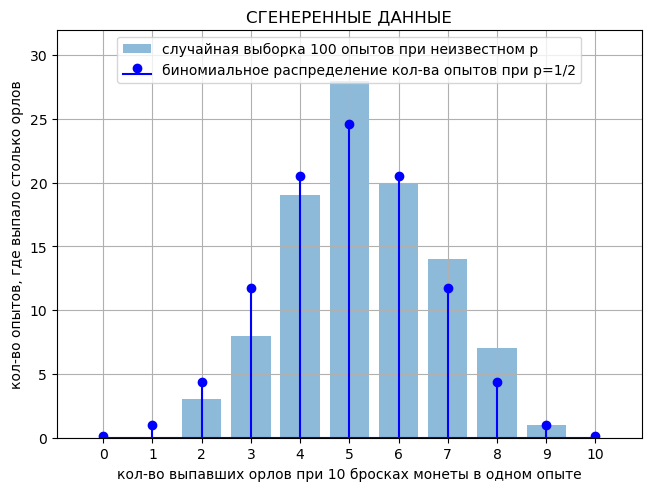

In [6]:
binom_bins = [-0.5 + i for i in range(n+2)]
x=range(n+1)
y=[nof_rep*st.binom.pmf(k,n,0.5) for k in range(n+1)]

plt.figure(layout='constrained')
plt.hist(X.sum(axis=1), bins=binom_bins, rwidth=0.8, alpha=0.5, 
         label='случайная выборка '+str(nof_rep)+' опытов при неизвестном p')
plt.stem(x,y, linefmt='blue', markerfmt='o', basefmt='blue', 
         label='биномиальное распределение кол-ва опытов при p=1/2')

plt.title('СГЕНЕРЕННЫЕ ДАННЫЕ')
plt.xlabel('кол-во выпавших орлов при '+str(n)+' бросках монеты в одном опыте')
plt.ylabel('кол-во опытов, где выпало столько орлов')
plt.xticks(range(n+1))
plt.ylim(0,max(y)*1.3)
plt.grid()
plt.legend(loc='upper center')
plt.show()

# сперва посмотрим на частотные методы

## поиск оптимального значения $\theta$ методом максимальной (совместной) вероятности на данном эксперименте, точнее ее логарифма:

$$
P\,(\theta, \{x_i\}) = \prod_{\forall i}\, C_N^{x_i} \cdot \theta^{x_i} \cdot (1-\theta)^{N-x_i}
$$

$$
log \Bigl( P\,(\theta, \{x_i\}) \Bigr) = log(\theta)\cdot\sum_{\forall i}\,x_i - log(1-\theta)\cdot\sum_{\forall i}\,x_i + log(1-\theta)\cdot n\cdot N + const_{\theta}({x_i})
$$

$$
\frac{\partial}{\partial\theta}\; log \Bigl( P\,(\theta, \{x_i\}) \Bigr) = \left(\frac{1}{\theta} + \frac{1}{1-\theta}\right)\cdot\sum_{\forall i}\,x_i - \frac{n\cdot N}{1-\theta} \;\equiv\, 0
$$

$$
p_{best} \approx \theta_{max(P)} = \frac{\sum\,x_i}{n\cdot N}
$$

In [7]:
print('\n Наилучшая частотная оценка неизвестного параметра монетки p =', X.sum()/nof_rep/n, '\n')


 Наилучшая частотная оценка неизвестного параметра монетки p = 0.529 



однако, не ясно каков доверительный интервал у этого оптимума по $P\,(\theta, \{x_i\})$

**заметим, что хотя аналитическая формула для $p_{best}$ выглядит очевидно - матожидание опытов с Бернулли даст $p$, а матожидание Бинома даст $p\cdot N$, - но вопрос был не про матожидания, а про лучший вариант для $p$ на данном эксперименте $\{x_i\}$**

## оценка и оптимального $p$ монеты и ее доверительного интервала дает ЦПТ

In [8]:
print('\nС достоверностью 95% вероятность орла у монетки  p = ', round((X.sum(axis=1)/n).mean(),4), 
      '+/-', round(1.96*(X.sum(axis=1)/n).std()/np.sqrt(nof_rep-1), 4),'\n')


С достоверностью 95% вероятность орла у монетки  p =  0.529 +/- 0.0295 



### ЦПТ можно применить и без мысленного разбиения всех подбрасываний на серии и опыты

In [9]:
print('\nС достоверностью 95% вероятность орла у монетки  p = ', round(X.reshape(-1).mean(),4), 
      '+/-', round(1.96*(X.reshape(-1).std())/np.sqrt(nof_rep*n-1), 4),'\n')


С достоверностью 95% вероятность орла у монетки  p =  0.529 +/- 0.031 



**Как видно, мощности эксперимента из серий по 10 со 100 повторами, равно как и просто 1000 подбрасываний, одинаково недостаточно для детектирования дисбаланса монетки менее чем на 0.03**

**слабая разница с диапазоне 95% доверительного интервала объясняется тем, что мы брали диапазон 1.96 для нормального распределения, которое лишь аппроксимирует истинную Z-статистику для 100 и для 1000 опытов с разной погрешностью - точнее для 1000**

# теперь применим вероятностный метод Байеса

$$
P(\theta / A) = \frac{P(A / \theta) \cdot \rho(\theta)}{\int\limits_0^1 P(A / \theta)\, \rho(\theta)\, d\theta}
$$

$$
P(A / \theta) = C_n^k \cdot \theta^k \cdot (1-\theta)^{n-k}
$$

## сперва попробуем искать доверительный интервал $\theta$ сопряженными функциями

$$
\rho(\theta) = B\,(\theta,\alpha,\beta)
$$
$\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\text{где апостериорные параметры пересчитываются так:}$
$$
\begin{eqnarray}
\alpha_{post} &=& \alpha_{prior} \;+ \sum_{\forall\;\text{повторы}} x_i \\
\beta_{post}  &=& \beta_{prior}   \;+ \;n\cdot N \;- \sum_{\forall\;\text{повторы}} x_i
\end{eqnarray}
$$

возьмем априорные параметры из матожидания *честной* монетки как:

$$
\begin{eqnarray}
\alpha_{prior} &=& 0.5\cdot N \\
\beta_{prior}  &=& 0.5\cdot N 
\end{eqnarray}
$$

In [10]:
a_pr = 0.5 * X.shape[1]
b_pr = 0.5 * X.shape[1]

a_ps = a_pr + X.sum()
b_ps = b_pr + X.shape[1] * X.shape[0] - X.sum()

print((a_pr, b_pr), ' -->> ', (float(a_ps), float(b_ps)))

(5.0, 5.0)  -->>  (534.0, 476.0)


### визуализация и сравнение с доверительным интервалом по ЦПТ 

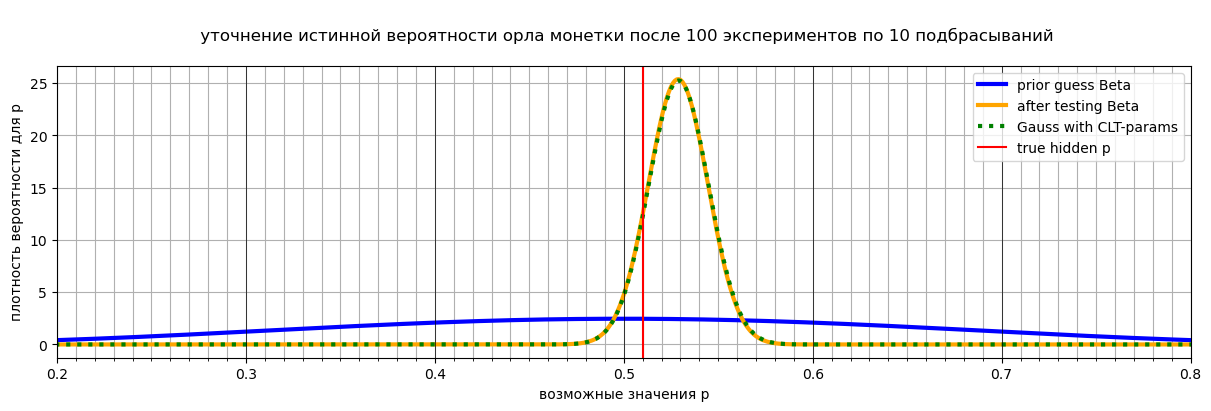

In [11]:
th_list = [i/1000 for i in range(1001)]
rho_pr = [st.beta.pdf(th, a_pr, b_pr) for th in th_list]
rho_ps = [st.beta.pdf(th, a_ps, b_ps) for th in th_list]
rho_norm = [st.norm.pdf(th, X.reshape(-1).mean(), X.reshape(-1).std()/np.sqrt(nof_rep*n-1)) for th in th_list]

plt.figure(figsize=(12,4), layout='constrained')

plt.plot(th_list, rho_pr, lw=3 , color='blue', label='prior guess Beta')
plt.plot(th_list, rho_ps, lw=3 , color='orange',label='after testing Beta')
plt.plot(th_list, rho_norm, lw=3, ls=':' , color='green',label='Gauss with CLT-params')

plt.xticks([i/10 for i in range(11)])
plt.xticks([i/100 for i in range(101)], minor=True)
for i in range(11):
    plt.axvline(i/10, color='black', lw=0.5)
plt.axvline(p, color='red', lw=1.5, label='true hidden p')

plt.xlim(0.2,0.8)
plt.grid(which='both')
plt.legend()
plt.title('\n уточнение истинной вероятности орла монетки после 100 экспериментов по 10 подбрасываний\n')
plt.xlabel('возможные значения p')
plt.ylabel('плотность вероятности для p')
plt.ylabel
plt.show()

### ВЫВОДЫ: 
1) **и ЦПТ статистик эксперимента и постериорный эксперименту Байес с сопряженным распределением дают одинаковые доверительные интервалы для неизвестного параметра $\theta$**
2) **все сплошные кривые на рисунке выше, хоть и выглядят как нормальное распределение с оценкой параметров по ЦПТ (показано пунктиром), но на самом деле являются поточечными графиками априорного и апостериорного Бета-распределения $P(\theta)$ и $P(\theta/\{x_i\})$ , где $\{x_i\}$ - результаты эксперимента с монеткой в начале блокнота**
3) **можно несколько раз перезапустить блокнот сначала, получая различные результаты эксперимента слева и справа от скрытого значения**

# применим библиотеку PyPM 

In [12]:
with pm.Model() as model:
  mu = pm.Normal("mu", mu=0.5, sigma=0.5)
  obs = pm.Binomial("obs", n=n, p=mu, observed=X.sum(axis=1))

  step = pm.NUTS()
  trace = pm.sample(1000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
/home/GD/sevastyanov.a/anaconda3/envs/py31211_ML1_PyMC/lib/python3.12/site-packages/pytensor/scalar/basic.py:3153: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(x)
/home/GD/sevastyanov.a/anaconda3/envs/py31211_ML1_PyMC/lib/python3.12/site-packages/pytensor/scalar/basic.py:3153: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(x)
/home/GD/sevastyanov.a/anaconda3/envs/py31211_ML1_PyMC/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/GD/sevastyanov.a/anaconda3/envs/py31211_ML1_PyMC/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/GD/sevastyanov.a/anaconda3/envs/py31211_ML1_PyMC/lib/python3.12/site-packages/pytensor/scalar/basic.py:3153:

Output()

/home/GD/sevastyanov.a/anaconda3/envs/py31211_ML1_PyMC/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/home/GD/sevastyanov.a/anaconda3/envs/py31211_ML1_PyMC/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:710: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>]],
      dtype=object)

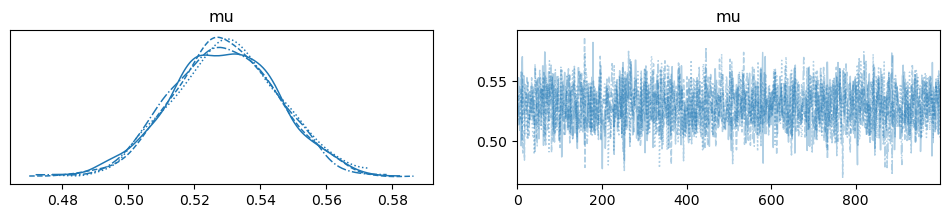

In [13]:
az.plot_trace(trace)

**Ай, шайтанский шайтан!  Ну что тут можно добавить к этому чуду техники - домашка №5 закончена, товарищи!**

In [14]:
myrun_stop = datetime.now()
print('TOTAL RUN TIME was', round((myrun_stop-myrun_start).total_seconds()), 'seconds')
print('Last run on', str(myrun_stop).split('.')[0])

TOTAL RUN TIME was 36 seconds
Last run on 2025-12-25 19:55:18
